In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)	
# check scikit-learn version
import sklearn
print('sklearn: %s' % sklearn.__version__)

sklearn: 0.22.2.post1


In [3]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from pylab import rcParams
from google.colab import files
from sklearn.model_selection import StratifiedShuffleSplit
from google.colab import drive
from sklearn.metrics import roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE
import nibabel as nib
import PIL   
from PIL import Image
import imgaug as ia
import imgaug.augmenters as iaa
import cv2

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

Version:  2.4.1
Eager mode:  True
GPU is available


In [4]:
import sys
import random
import warnings

import math
import seaborn as sns; sns.set()
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from keras.callbacks import Callback
from keras.losses import binary_crossentropy
from keras.models import Model, load_model, Sequential
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout, Flatten
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from keras import backend as K
import joblib
import gc

In [5]:
raw_data = pd.read_csv('/content/drive/MyDrive/Kaggle data/metadata.csv')
raw_data.head(5)

ct_scan  ...                            lung_and_infection_mask
0  /content/drive/MyDrive/Kaggle data/ct_scans/co...  ...  /content/drive/MyDrive/Kaggle data/lung_and_in...
1  /content/drive/MyDrive/Kaggle data/ct_scans/co...  ...  /content/drive/MyDrive/Kaggle data/lung_and_in...
2  /content/drive/MyDrive/Kaggle data/ct_scans/co...  ...  /content/drive/MyDrive/Kaggle data/lung_and_in...
3  /content/drive/MyDrive/Kaggle data/ct_scans/co...  ...  /content/drive/MyDrive/Kaggle data/lung_and_in...
4  /content/drive/MyDrive/Kaggle data/ct_scans/co...  ...  /content/drive/MyDrive/Kaggle data/lung_and_in...

[5 rows x 4 columns]

In [6]:
ct_scan_path=np.array(raw_data['ct_scan'])
lung_mask_path=np.array(raw_data['lung_mask'])
infection_mask_path=np.array(raw_data['infection_mask'])
both_mask_path=np.array(raw_data['lung_and_infection_mask'])

In [7]:
ct_scan_path[0]

'/content/drive/MyDrive/Kaggle data/ct_scans/coronacases_org_001.nii'

In [8]:
def plot_sample(array_list, color_map = 'nipy_spectral'):
    fig = plt.figure(figsize=(18,15))

    plt.subplot(1,4,1)
    plt.imshow(array_list[0], cmap='bone')
    plt.title('Original Image')
    plt.grid(None) 

    plt.subplot(1,4,2)
    plt.imshow(array_list[0], cmap='bone')
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    plt.title('Lung Mask')
    plt.grid(None)

    plt.subplot(1,4,3)
    plt.imshow(array_list[0], cmap='bone')
    plt.imshow(array_list[2], alpha=0.5, cmap=color_map)
    plt.title('Infection Mask')
    plt.grid(None)

    plt.subplot(1,4,4)
    plt.imshow(array_list[0], cmap='bone')
    plt.imshow(array_list[2], alpha=0.5, cmap=color_map)
    plt.title('Lung and Infection Mask')
    plt.grid(None)

    plt.show()

In [9]:
def enhanced_img(test_img,visualize):
  test_img = test_img*255
  test_img = np.uint8(test_img)
  clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
  clahe_image = clahe.apply(test_img)     # parameter passed must be of dtype uint8

  if(visualize==1):
    fig = plt.figure(figsize=(12,15))
    plt.subplot(1, 2, 1)
    plt.imshow(test_img, cmap='bone')
    plt.title("Original CT-Scan")
    plt.grid(None)
  
    plt.subplot(1,2,2)
    plt.imshow(clahe_image, cmap='bone')
    plt.title("Enhanced CT-Scan")
    plt.grid(None)
    
  return clahe_image   

* First Tried Manually cropping the image but it doesn't work out .
* So, now cropping the image using contours.
* From Lung mask Take contour along left lung and crop the img of left lung.
* Then from the 2nd Lung, take contour along the second Lung and crop it.
* Finally combine the both Cropped images to get the final croppped img.
* Now store the contours points because to Crop the  Ctscan and mask corresponding to each Ctscan.

In [10]:
def cropped_img(test_img,visualize):
  test_img=test_img*255
  test_img=np.uint8(test_img)
  
  contours,hierarchy = cv2.findContours(test_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  contours = sorted(contours, key=cv2.contourArea, reverse=True)
  #print(len(contours)) size=2 for both lungs

  lung1_pt=[]
  lung2_pt=[]

  # left lung
  cnt1=contours[0]  
  x,y,w,z=cv2.boundingRect(cnt1)
  crp_1=test_img[y:y+z,x:x+w]
  crp_1 = cv2.resize(crp_1, dsize=(125,250), interpolation=cv2.INTER_AREA)     
  lung1_pt.append(x);lung1_pt.append(y);lung1_pt.append(w);lung1_pt.append(z);

  crp_2=crp_1
  #Right lung
  if(len(contours)==2):
    cnt2=contours[1]
    p,q,r,s=cv2.boundingRect(cnt2)
    crp_2=test_img[q:q+s,p:p+r]
    crp_2 = cv2.resize(crp_2, dsize=(125,250), interpolation=cv2.INTER_AREA)
    lung2_pt.append(p);lung2_pt.append(q);lung2_pt.append(r);lung2_pt.append(s);
  else:
    lung2_pt.append(x);lung2_pt.append(y);lung2_pt.append(w);lung2_pt.append(z);
    # before merging two image dimensions of 2 image must be same
  ROI = np.concatenate((crp_1, crp_2), axis=1)  

  if(visualize==1):
    fig = plt.figure(figsize=(10,8))
    plt.subplot(1,3,1)
    plt.imshow(crp_1)
    plt.grid(None)

    plt.subplot(1,3,2)
    plt.imshow(crp_2)
    plt.grid(None)

    plt.subplot(1,3,3)
    plt.imshow(ROI)
    plt.grid(None)

    plt.show()
  
  return (ROI,lung1_pt,lung2_pt)


In [11]:
points_1=[]
points_2=[]
img_size=512

In [12]:
def read_nii(filepath,img_arr,string):

    global points_1
    global points_2
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array))
    slices = array.shape[2]
    #get the slices b/w 20% and 80%
    array = array[:,:,round(slices*0.25):round(slices*0.75)]
    array = np.reshape(np.rollaxis(array, 2),(array.shape[2],array.shape[0],array.shape[1],1))
    
    if string=='lungs':
      points_1=[]
      points_2=[]

    for img_no in range(0, array.shape[0]):
      if string=='lungs' and np.unique(array[img_no]).size == 1:
        continue
      img = cv2.resize(array[img_no], dsize=(img_size, img_size), interpolation=cv2.INTER_AREA)  #resizing all images to the same dimensions
      # Normalising the Image
      xmax, xmin = img.max(), img.min()
      img = (img - xmin)/(xmax - xmin)
      
      if string == 'lungs':
          # img = np.uint8(img*255) 
          img[img>0]=1
          img, pts1, pts2 = cropped_img(img, visualize= 0)
          points_1.append((pts1[0], pts1[1], pts1[2], pts1[3]))
          points_2.append((pts2[0], pts2[1], pts2[2], pts2[3]))
          continue 

      if string == "cts" and img_no < len(points_1):
          img = enhanced_img(img, visualize= 0)
          a,b,c,d = points_1[img_no]
          e,f,g,h = points_2[img_no]
          img1 = img[b:b+d, a:a+c]
          img1 = cv2.resize(img1, dsize=(125,250), interpolation=cv2.INTER_AREA)
          img2 = img[f:f+h, e:e+g]
          img2 = cv2.resize(img2, dsize=(125,250), interpolation=cv2.INTER_AREA)
          img = np.concatenate((img1, img2), axis=1)    

      if string == "infections" and img_no < len(points_2):
          a,b,c,d = points_1[img_no]
          e,f,g,h = points_2[img_no]
          img = np.uint8(img*255)
          img1 = img[b:b+d, a:a+c]
          img1 = cv2.resize(img1, dsize=(125,250), interpolation=cv2.INTER_AREA)
          img2 = img[f:f+h, e:e+g]
          img2 = cv2.resize(img2, dsize=(125,250), interpolation=cv2.INTER_AREA)
          img = np.concatenate((img1, img2), axis=1)

        
      img_arr.append(img)

In [13]:
cts = []
lungs = []
infections = []

for i in range(0, 20):
  read_nii(raw_data.loc[i,'lung_mask'], lungs, 'lungs')
  read_nii(raw_data.loc[i,'ct_scan'], cts, 'cts') 
  read_nii(raw_data.loc[i,'infection_mask'], infections, 'infections')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


(250, 250) (250, 250)


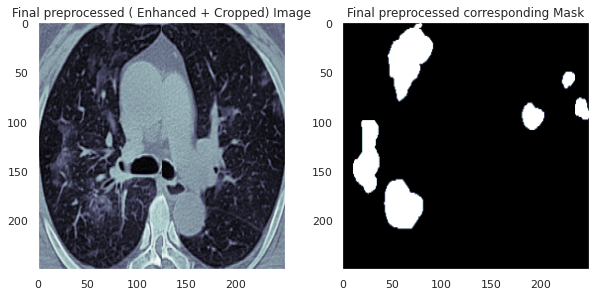

In [14]:
ind = 121
rcParams['figure.figsize'] = 10,10


plt.subplot(2, 2, 1)
plt.imshow(cts[ind], cmap='bone')
plt.title("Final preprocessed ( Enhanced + Cropped) Image")
plt.grid(None)

plt.subplot(2, 2, 2)
plt.imshow(infections[ind], cmap='bone')
plt.title("Final preprocessed corresponding Mask")
plt.grid(None)

print(cts[ind].shape, infections[ind].shape)

In [15]:
 print(len(cts))
 print(len(lungs))
 print(len(infections))

1766
0
1766


In [16]:
new_dim=224

In [17]:
for i in range(0,len(cts)):
  cts[i] = cv2.resize(cts[i], dsize=(new_dim, new_dim), interpolation=cv2.INTER_LINEAR)
  infections[i] = cv2.resize(infections[i], dsize=(new_dim, new_dim), interpolation=cv2.INTER_LINEAR)
  
cts = np.array(cts)
infections = np.array(infections)

cts = np.uint8(cts)
infections = np.uint8(infections)

In [18]:
def plot_processed_sample(array_list, color_map = 'nipy_spectral'):
   
    fig = plt.figure(figsize=(10,8))

    plt.subplot(1,2,1)
    plt.imshow(array_list[0].reshape(new_dim, new_dim), cmap='bone')
    plt.title('Original Image')
    plt.grid(None)


    plt.subplot(1,2,2)
    plt.imshow(array_list[0].reshape(new_dim, new_dim), cmap='bone')
    plt.imshow(array_list[1].reshape(new_dim, new_dim), alpha=0.5, cmap=color_map)
    plt.title('Infection Mask')
    plt.grid(None)

    plt.show()

Overlaying Infection mask Over Lungs and Plotting some Samples

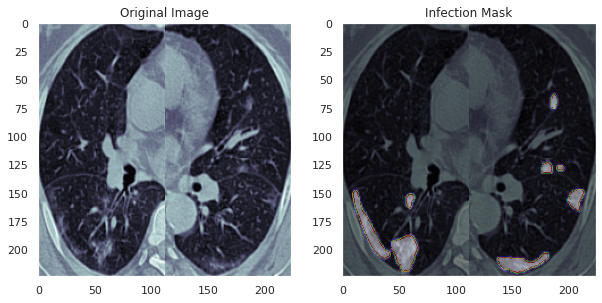

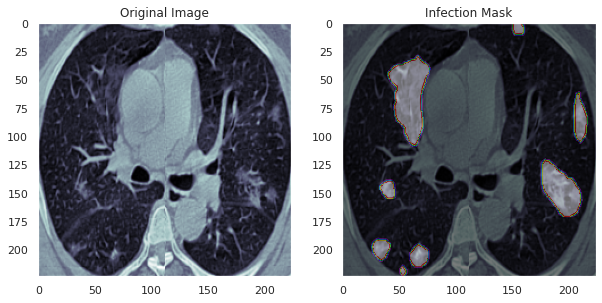

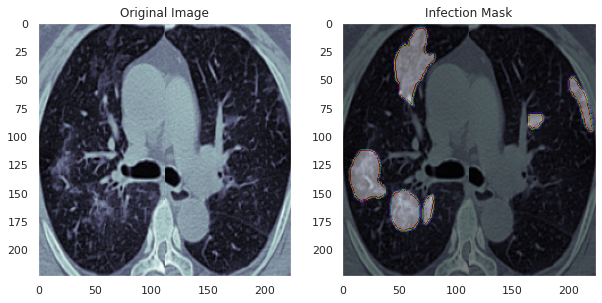

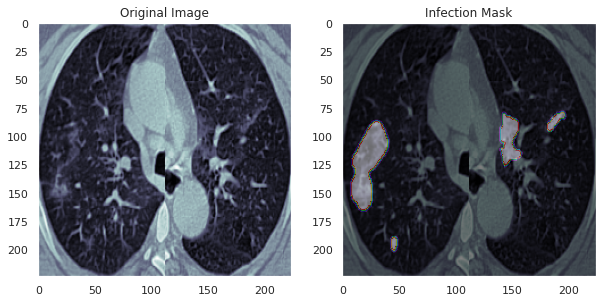

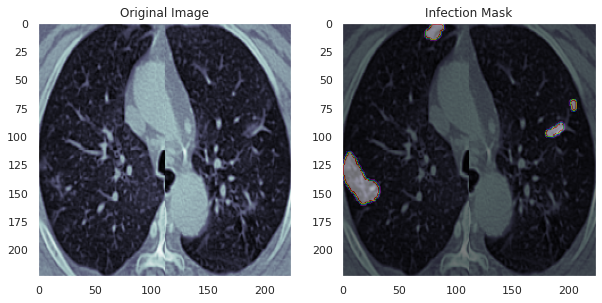

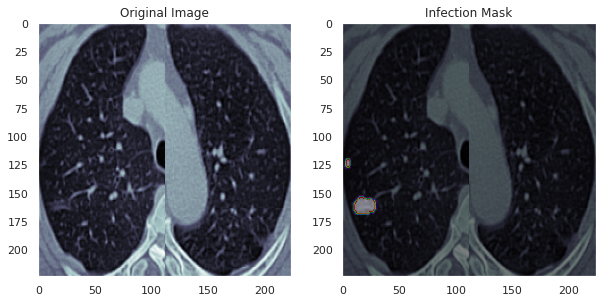

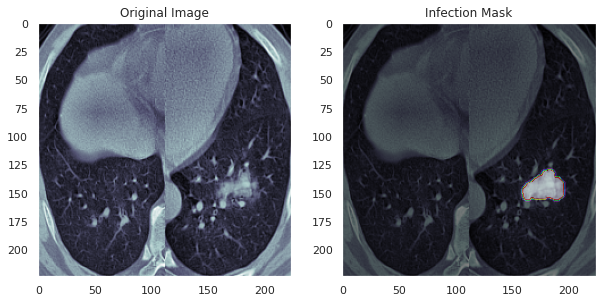

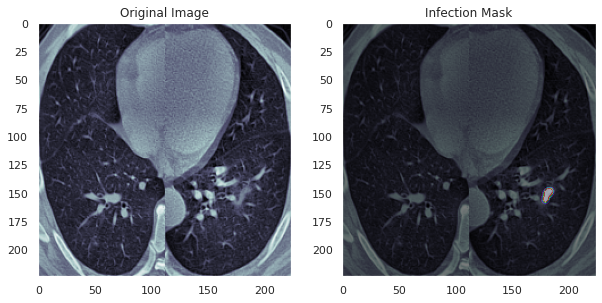

In [19]:
for index in [90,110,120,135,140,150,170,180]:
    plot_processed_sample([cts[index], infections[index]])

In [20]:
print(cts[1].min(),"min")
print(cts[1].max(),"max")
print(infections[1].min(),"min")
print(infections[1].max(),"max")

2 min
240 max
0 min
0 max


In [21]:
print(cts[1].shape)
print(len(cts))
print(type(cts))
print(cts[1278].shape)

(224, 224)
1766
<class 'numpy.ndarray'>
(224, 224)


Data Augmentation

In [22]:
sometimes = lambda aug: iaa.Sometimes(0.5, aug)

seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontally flip 50% of all images
    iaa.Flipud(0.2), # vertically flip 20% of all images
    iaa.Sharpen(alpha=(0, 1.0), lightness=(0.80, 1.5)),
    iaa.LinearContrast((0.90, 1.5)),
    sometimes(iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
            rotate=(-30, 30), # rotate by -30 to +30 degrees
        ))
], random_order=True)


In [23]:
no_of_aug_imgs = 334
random_indices = np.random.randint(0, cts.shape[0], size=no_of_aug_imgs)
sample_cts = cts[random_indices]
sample_inf = infections[random_indices]

In [24]:
ctsa=seq(images=sample_cts)
infa=seq(images=sample_inf)
print(ctsa.shape, infa.shape)

(334, 224, 224) (334, 224, 224)


In [25]:
rcParams['figure.figsize'] = 60,60
rand = np.random.randint(0, no_of_aug_imgs, size=5)

print(type(rand), len(rand))

<class 'numpy.ndarray'> 5


In [26]:
cells1 = [ctsa[i] for i in rand]
cells2 = [infa[i] for i in rand]

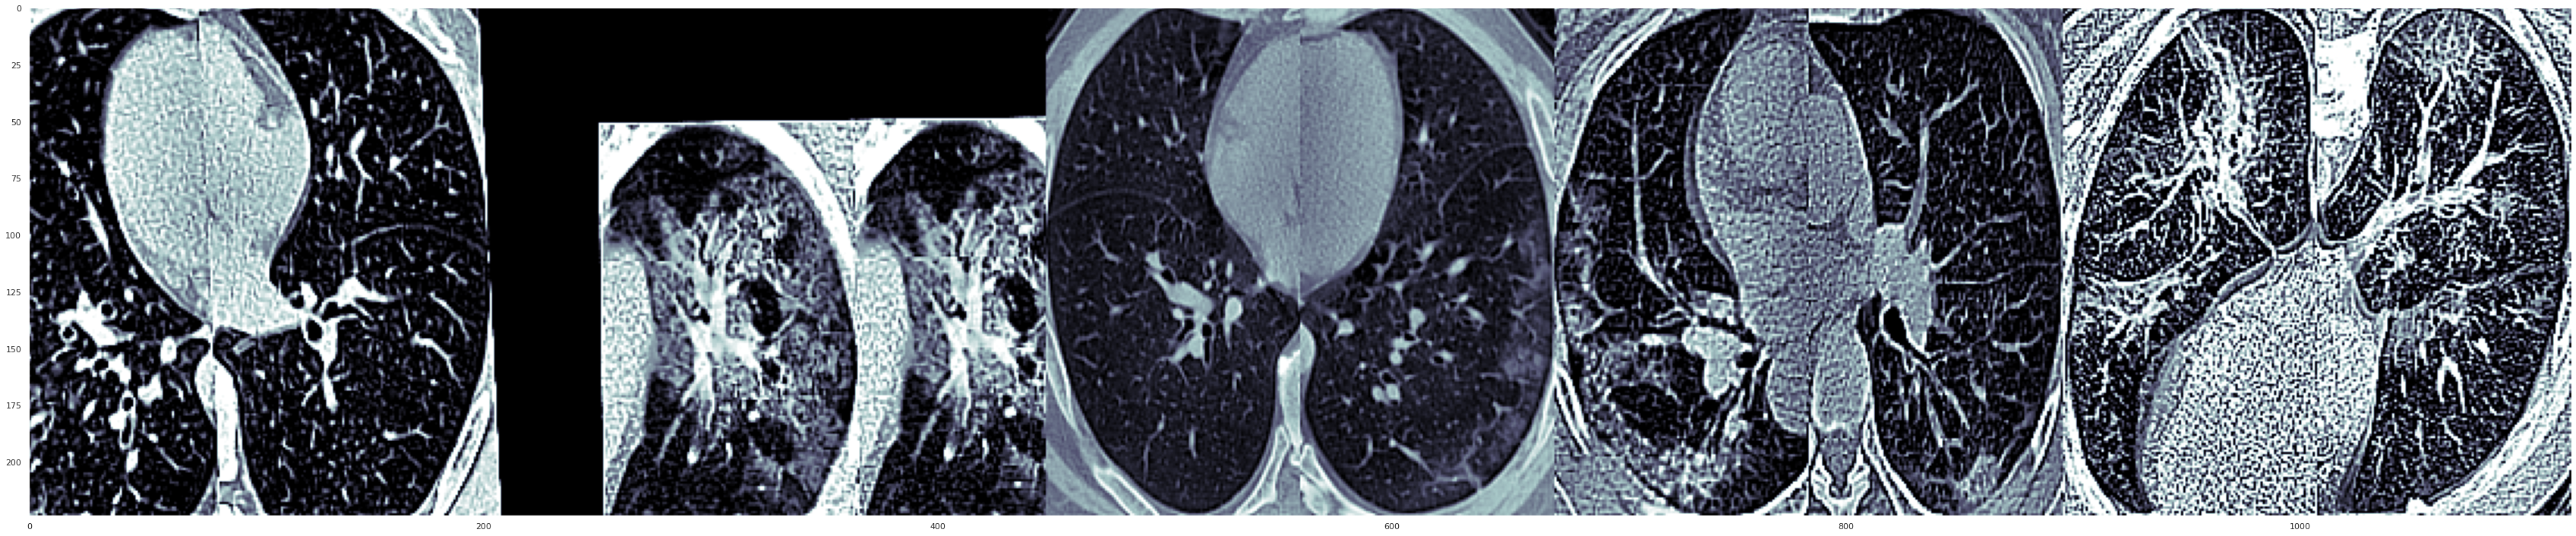

In [27]:
grid_image1 = np.hstack(cells1)
plt.grid(False)
plt.imshow(grid_image1, cmap = 'bone')

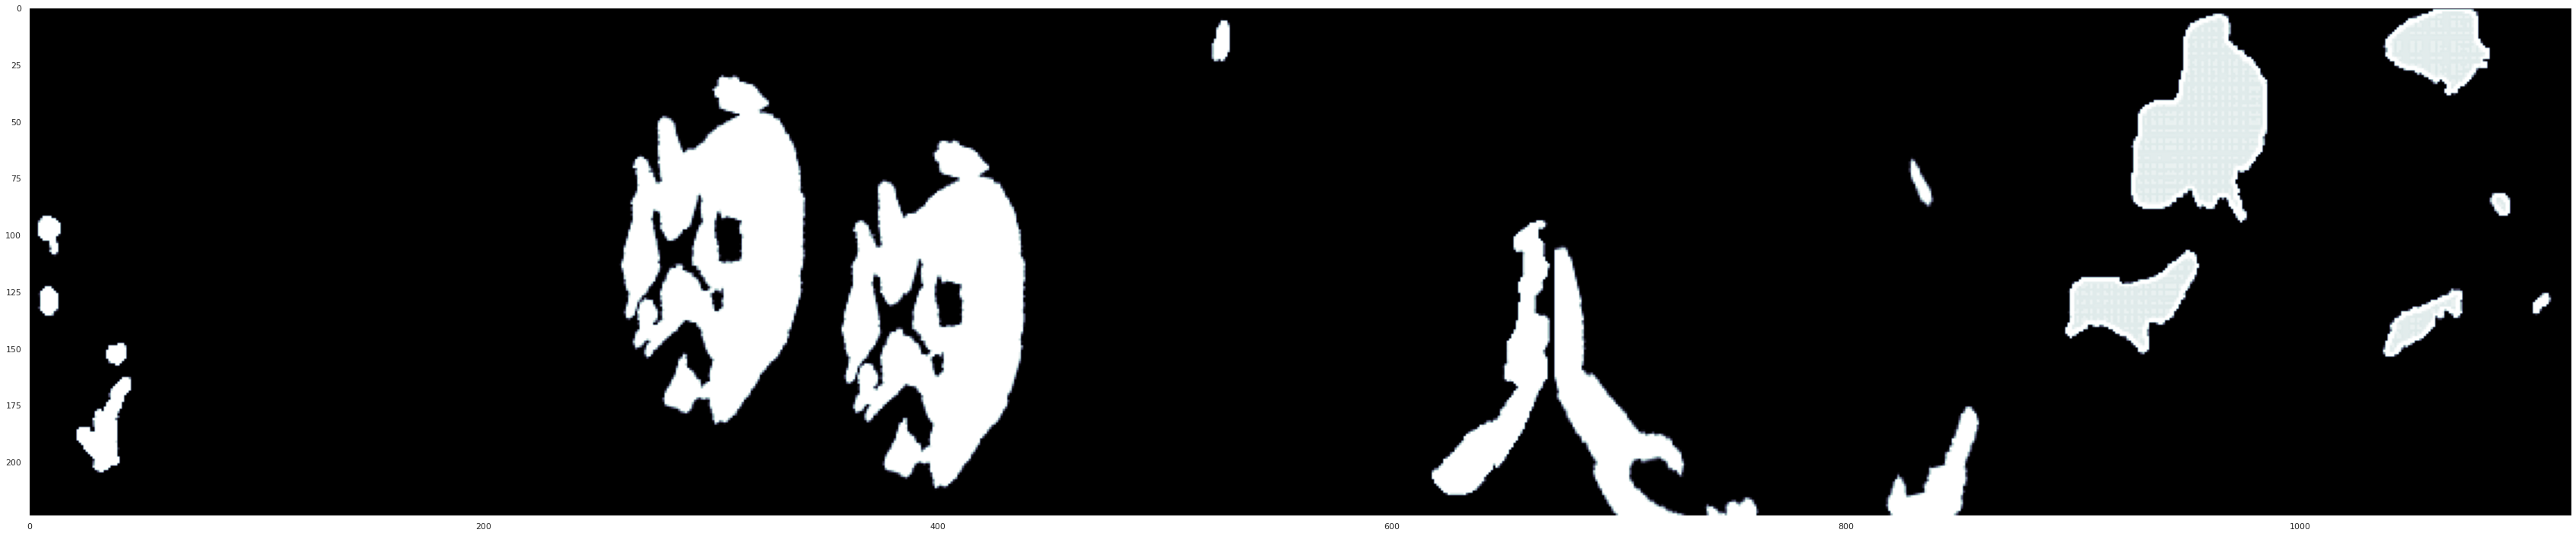

In [28]:
grid_image2 = np.hstack(cells2)
plt.grid(False)
plt.imshow(grid_image2, cmap = 'bone')

In [29]:
cts = np.concatenate((cts, ctsa), axis=0)
infections = np.concatenate((infections, infa), axis = 0)
print(cts.shape, infections.shape)
print(cts.min())
print(cts.max())

(2100, 224, 224) (2100, 224, 224)
0
255


Normalising Images

In [30]:
cts=(cts-cts.min())/(cts.max()-cts.min())
infections=(infections-infections.min())/(infections.max()-infections.min())

print(cts.min(), cts.max())
print(infections.min(), infections.max())


0.0 1.0
0.0 1.0


In [31]:
cts = cts.reshape(len(cts), new_dim, new_dim, 1)
infections = infections.reshape(len(infections), new_dim, new_dim, 1)

print(len(cts), len(infections))
print(cts.shape, infections.shape)

2100 2100
(2100, 224, 224, 1) (2100, 224, 224, 1)


In [32]:
y_label = []
for i in range(0, len(infections)):
    if len(np.unique(infections[i]))!=1:
        y_label.append(1)
    else:
        y_label.append(0)
    
print(y_label.count(0), y_label.count(1))

440 1660


In [33]:
y_label=np.asarray(y_label)

In [34]:
print(type(cts), type(y_label))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


SMOTE CODE

In [35]:
dim_1 = np.array(cts).shape[0]
dim_2 = np.array(cts).shape[1]
dim_3 = np.array(cts).shape[2]
new_dim = dim_1 * dim_2

new_x_train = np.array(cts).reshape(new_dim, dim_3)
new_y_train = []
for i in range(len(y_label)):
    # print(y_train[i])
    new_y_train.extend([y_label[i]]*dim_2)

new_y_train = np.array(new_y_train)


The cell below takes longer than average to run. Took me around 2hrs.

In [36]:
# transform the dataset
oversample = SMOTE()
X_Train, Y_Train = oversample.fit_sample(new_x_train, new_y_train)
print(len(Y_Train))

x_train_SMOTE = X_Train.reshape(int(X_Train.shape[0]/dim_2), dim_2, dim_3)
y_train_SMOTE = []

743680


In [37]:
for i in range(int(X_Train.shape[0]/dim_2)):
    value_list = list(Y_Train.reshape(int(X_Train.shape[0]/dim_2), dim_2)[i])
    y_train_SMOTE.extend(list(set(value_list)))
    ## Check: if there is any different value in a list 
    if len(set(value_list)) != 1:
        print('\n\n********* STOP: THERE IS SOMETHING WRONG IN TRAIN ******\n\n')
        

In [38]:
y_train_SMOTE=np.asarray(y_train_SMOTE)

In [39]:
print(type(cts), type(y_label))
print(len(cts), len(y_label))


<class 'numpy.ndarray'> <class 'numpy.ndarray'>
2100 2100


In [40]:
print(type(x_train_SMOTE), type(y_train_SMOTE))
print(len(x_train_SMOTE), len(y_train_SMOTE))


<class 'numpy.ndarray'> <class 'numpy.ndarray'>
3320 3320


In [98]:
X=x_train_SMOTE
y=y_train_SMOTE

print(type(X), type(y))
print(len(X), len(y))


<class 'numpy.ndarray'> <class 'numpy.ndarray'>
3320 3320


Preprocessing Complete

In [99]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.24, random_state=42)
for train, test in sss.split(X, y):
  x_train, x_valid = X[train], X[test]
  y_train, y_valid = y[train], y[test]


In [100]:
print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)

(2523, 224, 224) (2523,)
(797, 224, 224) (797,)


In [101]:
x_train = x_train.reshape(len(x_train), 224, 224, 1)
x_valid = x_valid.reshape(len(x_valid), 224, 224, 1)

In [102]:
print(x_train.shape)

(2523, 224, 224, 1)


In [103]:
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    precision_t = precision(y_true, y_pred)
    recall_t = recall(y_true, y_pred)
    return 2*((precision_t*recall_t)/(precision_t+recall_t+K.epsilon()))


In [104]:
batch_size = 32
epochs = 50

pat = 15
#this is the number of epochs with no improvment after which the training will stop
early_stopping = EarlyStopping(monitor='f1_score', patience=pat, verbose=1)

#define the model checkpoint callback -> this will keep on saving the model as a physical file
model_checkpoint = ModelCheckpoint('hard_proj.h5', verbose=1, save_best_only=True)

Layered

In [105]:
model = Sequential()

model.add(Conv2D(16, (3, 3), activation='relu', padding="same", kernel_initializer="he_normal", input_shape=(224, 224, 1)))
model.add(BatchNormalization())
model.add(Conv2D(16, (3, 3), activation='relu', padding="same" , kernel_initializer="he_normal"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu', padding="same" , kernel_initializer="he_normal"))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Conv2D(32, (3, 3), activation='relu', padding="same" , kernel_initializer="he_normal"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', padding="same" , kernel_initializer="he_normal"))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', padding="same" , kernel_initializer="he_normal"))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(MaxPooling2D(pool_size=(2, 2))) 

model.add(Conv2D(96, (3, 3), activation='relu', padding="same", kernel_initializer="he_normal"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1 , activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001), metrics=[f1])

In [106]:
result=model.fit(x_train, y_train, epochs = epochs, validation_data = (x_valid, y_valid))

Epoch 1/50
79/79 [==============================] - 8s 91ms/step - loss: 0.9988 - f1: 0.7887 - val_loss: 0.5449 - val_f1: 0.8907
Epoch 2/50
79/79 [==============================] - 7s 85ms/step - loss: 0.2055 - f1: 0.9007 - val_loss: 0.4171 - val_f1: 0.8874
Epoch 3/50
79/79 [==============================] - 7s 86ms/step - loss: 0.1656 - f1: 0.9066 - val_loss: 0.3369 - val_f1: 0.8939
Epoch 4/50
79/79 [==============================] - 7s 87ms/step - loss: 0.1260 - f1: 0.9592 - val_loss: 0.2317 - val_f1: 0.9250
Epoch 5/50
79/79 [==============================] - 7s 87ms/step - loss: 0.1219 - f1: 0.9466 - val_loss: 0.1562 - val_f1: 0.9503
Epoch 6/50
79/79 [==============================] - 7s 88ms/step - loss: 0.0828 - f1: 0.9687 - val_loss: 0.1354 - val_f1: 0.9507
Epoch 7/50
79/79 [==============================] - 7s 88ms/step - loss: 0.0362 - f1: 0.9863 - val_loss: 0.1814 - val_f1: 0.9629
Epoch 8/50
79/79 [==============================] - 7s 88ms/step - loss: 0.0429 - f1: 0.9818 - va

In [107]:
score = model.evaluate(x_valid, y_valid, batch_size=32)
print("test loss:" , score[0], "\ntest f1 score:" , score[1])

25/25 [==============================] - 1s 22ms/step - loss: 0.2300 - f1: 0.9664
test loss: 0.22996877133846283 
test f1 score: 0.9663850665092468


RESULTS

In [111]:
#function to draw confusion matrix
def draw_confusion_matrix(true,preds):
    conf_matx = confusion_matrix(true, preds)
    sns.heatmap(conf_matx, annot=True,annot_kws={"size": 12},fmt='g', cbar=False, cmap="viridis")
    plt.show()

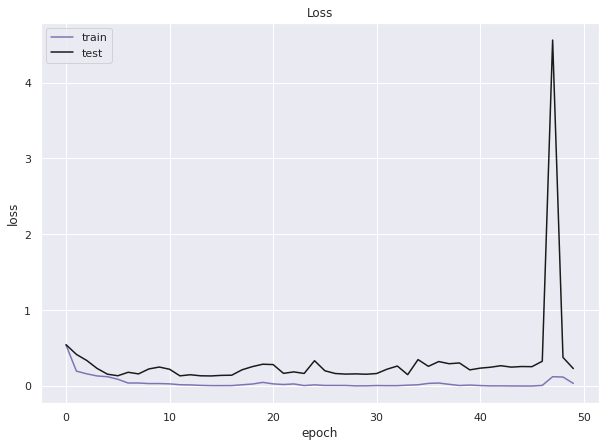

In [112]:
rcParams['figure.figsize'] = 10,7
plt.grid('True')
plt.plot(result.history['loss'], color='m')
plt.plot(result.history['val_loss'], color='k')
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [113]:
prediction = model.predict(x_valid)
prediction = np.array(prediction.flatten())

pred = prediction.astype(np.uint8)

In [114]:
print(confusion_matrix(y_valid, pred))
print("precision: ", precision_score(y_valid, pred))
print("recall: ", recall_score(y_valid, pred))
print("f1_score: ", f1_score(y_valid, pred))
print("ROC AUC score", roc_auc_score(y_valid, pred))

[[397   2]
 [193 205]]
precision:  0.9903381642512077
recall:  0.5150753768844221
f1_score:  0.6776859504132231
ROC AUC score 0.7550314227780507


improving the model

In [120]:
def to_labels(pos_probs, threshold):
	return (pos_probs >= threshold).astype('int')

model

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


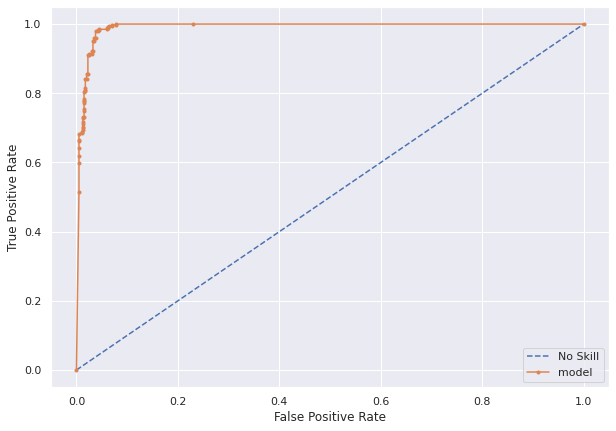

In [121]:
from sklearn.metrics import roc_curve
yhat = model.predict_proba(x_valid)
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_valid, yhat)
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

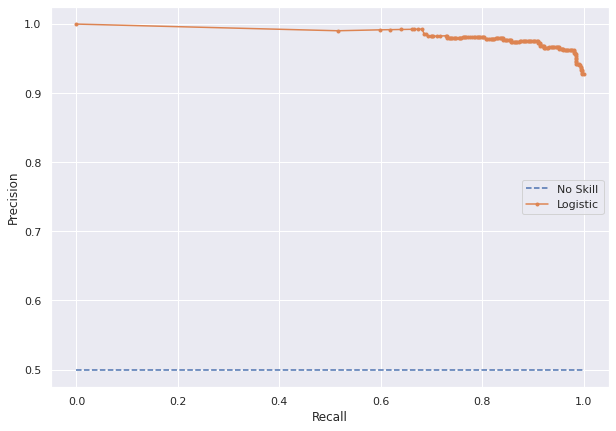

In [122]:
from sklearn.metrics import precision_recall_curve
from numpy import argmax
# calculate pr-curve
precision, recall, thresholds = precision_recall_curve(y_valid, yhat)
# plot the roc curve for the model
no_skill = len(y_valid[y_valid==1]) / len(y_valid)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='Logistic')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

Best Threshold=0.930714, F-Score=0.971


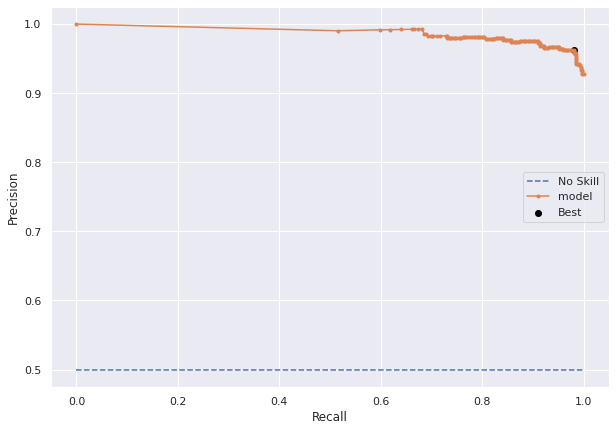

In [123]:
precision, recall, thresholds = precision_recall_curve(y_valid, yhat)
fscore = (2 * precision * recall) / (precision + recall)
ix = argmax(fscore)
threshold=thresholds[ix]
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
# plot the roc curve for the model
no_skill = len(y_valid[y_valid==1]) / len(y_valid)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='model')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

In [124]:
print(confusion_matrix(y_valid, to_labels(yhat, threshold)))
print("precision: ", precision_score(y_valid, to_labels(yhat, threshold)))
print("recall: ", recall_score(y_valid, to_labels(yhat, threshold)))
print("F1_score: ", f1_score(y_valid, to_labels(yhat, threshold)))
print("ROC AUC score", roc_auc_score(y_valid, to_labels(yhat, threshold)))

[[384  15]
 [  8 390]]
precision:  0.9629629629629629
recall:  0.9798994974874372
F1_score:  0.9713574097135741
ROC AUC score 0.9711527562625155


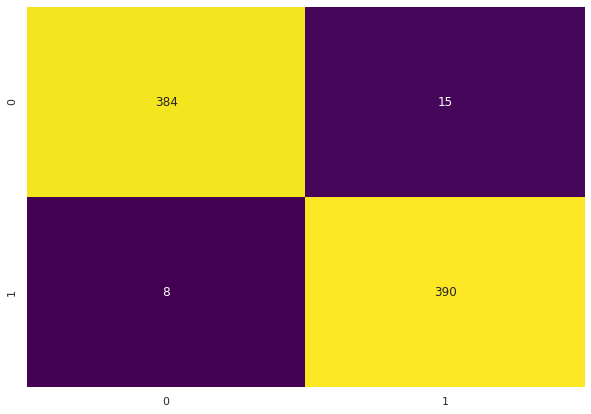

In [125]:
draw_confusion_matrix(y_valid,to_labels(yhat, threshold))

In [131]:
model.save('/content/drive/MyDrive/covid_classification_model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/covid_classification_model/assets
